# Practical for Seasonal Forecasts
In this practical, we will use some forecast models to generate some seaonal precipitation forecasts, and then assess how their raw forecasts compared with a technique to bias correct (i.e. postprocess) their outputs.

Postprocessing technique assessed will include Canonical Correlation Analysis (CCA), which bias corrects forecasts by seeking patterns across large spatial scales using Empirical Orthogonal Functions (EOFs).

The usefulness of this technique also depends on the observations used to train the model, we will compare data from University of California at Santa Barbara (UCSB) CHIRPS 5km rainfall data and CMORPH 0.25' data as options to train the CCA bias correction technique.

**This notebook should be run in the intdesk_train environment - check your kernel (upper righthand corner) is set to 'intdesk_train', so you have all necessary libraries**


## Libraries

In [94]:
import xcast as xc
import datetime as dt
from datetime import datetime
import numpy as np
from pathlib import Path
import xarray as xr
import os
import time
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import glob

import rioxarray
import geopandas as gpd
from shapely.geometry import mapping

# automatically reloads the configuration file once updated and saved so you don't have to restart the kernel
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Project Directory Setup

In [122]:
# setup the folder where you want to work for this project
# either type in the location, or place this notebook in the folder where you want your project to live and set project_dir = os.getcwd()
project_dir = os.getcwd()#"/Users/katie/Desktop/trial_pacisl" 

#make subdirectores to organize your work within the project if they don't already exist
os.makedirs(os.path.join(project_dir, 'practical_data'), exist_ok = True)
data_dir = os.path.join(project_dir, 'practical_data')
os.makedirs(os.path.join(data_dir, 'nc_files'), exist_ok = True)
nc_dir = os.path.join(data_dir, 'nc_files')
os.makedirs(os.path.join(project_dir, 'practical_figures'), exist_ok = True)
figure_dir = os.path.join(project_dir, 'practical_figures')

#shapefile directory
boundary_dir = os.path.join(project_dir, 'pacific_shapefile')

## Pick your Models, Observational Data, and Initialization Date

In [98]:
#Pick Some Forecast Models to Test
gcms = ['NMME']#'GEOSS2S','SPEAR', 'CCSM4', 'CanSIPSIC3', 'CFSv2', 
#Pick Some Observed Rainfall Data to Evaluate Predictions
# options include 'UCSB0p05', or 'CMORPH'
obs_name = 'CMORPH'

#Pick the date you want to initialize the model, e.g. your current date
initial_date = (2024, 2, 1)

#where you want to target your final analysis
predictand_extent = {
        'west':  153,
        'east': 183,  
        'north': 3,  
        'south': -20
      }

fiji_coordinates = {
        'west':  177,
        'east': 182,  
        'north': -15,  
        'south': -20}

kiribati_coordinates = {
        'west':  155,
        'east': 178,  
        'north': 2,  
        'south': 0}

solomon_coordinates = {
        'west':  155,
        'east': 167,  
        'north': -13,  
        'south': -6}

region_of_interest = 'kiribati'

## Prepare Data for Analysis

### Calculate Seasons to Forecast Based on Initialization Date

In [99]:
#this cell is setup to calculate your target forecast months based on your initialization date
#the forecast months are currently seto to be 1-3, 2-4 and 3-5 months ahead
number_to_month_name_dictionary = {
    1: 'Jan',
    2: 'Feb',
    3: 'Mar',
    4: 'Apr',
    5: 'May',
    6: 'Jun',
    7: 'Jul',
    8: 'Aug',
    9: 'Sep',
    10: 'Oct',
    11: 'Nov',
    12: 'Dec',
    0: 'Dec'
}

leads = [['1', '3'],['2', '4'], ['3','5']]
initial_month = dt.datetime(*initial_date).month
initial_month_name = number_to_month_name_dictionary[initial_month]
target_seas = []
for l in leads:
    target_low = number_to_month_name_dictionary[(initial_month + float(l[0]))%12]
    target_high = number_to_month_name_dictionary[(initial_month + float(l[1]))%12]
    target_seas.append('-'.join([target_low, target_high]))
print('Target seasons to forecast')
print(target_seas)

Target seasons to forecast
['Mar-May', 'Apr-Jun', 'May-Jul']


### Load Observations and Model Data

In [102]:
if obs_name == 'CMORPH':
    training_length = 'threeseas'
elif obs_name == 'CHIRPS':
    training_length = 'oneseas'
obs_leads = xr.open_dataset(os.path.join(nc_dir, '_'.join([initial_month_name, training_length, obs_name, 'precip.nc'])))

#if using cmorph data, crop cmorph data using an ocean mask 

if obs_name == 'CMORPH'
    obs_leads = obs_leads.rio.set_spatial_dims(x_dim='lon', y_dim='lat')
    obs_leads = obs_leads.rio.write_crs("EPSG:4326")
    shapefile = gpd.read_file(os.path.join(boundary_dir, 'pacific.shp'))
    if shapefile.crs is None:
        shapefile.set_crs("EPSG:4326", inplace=True)
    if shapefile.crs != obs_leads.rio.crs:
        shapefile = shapefile.to_crs(obs_leads.rio.crs)
    masked_obs = obs_leads.rio.clip(shapefile.geometry.apply(mapping), shapefile.crs)

# read in hindcast and forecast data
hindcast_data, forecast_data = [], []
for gcm in gcms:
    g = xr.open_dataset(os.path.join(nc_dir, '_'.join([initial_month_name, training_length, gcm, 'hcst_precip.nc'])))
    f = xr.open_dataset(os.path.join(nc_dir, '_'.join([initial_month_name, training_length, gcm, 'fcst_precip.nc'])))
    hindcast_data.append(g)
    forecast_data.append(f)
hindcast_data = xr.concat(hindcast_data, dim = 'M')
forecast_data = xr.concat(forecast_data, dim = 'M')

## Analysis

### Bias correct raw model outputs using Canonical Correlation Analysis (CCA)

In [108]:
start_time = time.time()
cca_fcsts_prob, cca_fcsts_det, cca_hcasts_det, cca_hcasts_prob, obs_to_test = [],[],[],[],[]

for l in np.unique(hindcast_data.L):
    model = hindcast_data.sel(L=l).precip
    obs = obs_leads.sel(L=l).precip
    fmodel = forecast_data.sel(L=l).precip

    #run CCA
    hindcasts_det, hindcasts_prob, obs_test = [], [], []
    i=1
    for xtrain, ytrain, xtest, ytest in xc.CrossValidator(model, obs, window=5):
        print("window {}".format(i))
        i += 1
        reg = xc.CCA(search_override=(8,
                                      8,
                                     3))
        reg.fit(xtrain, ytrain)
        preds = reg.predict(xtest)
        probs =  reg.predict_proba(xtest)
        obs_test.append(ytest)
        hindcasts_det.append(preds)
        hindcasts_prob.append(probs)
    hindcasts_det = xr.concat(hindcasts_det, 'T')
    hindcasts_prob = xr.concat(hindcasts_prob, 'T')
    obs_test = xr.concat(obs_test, 'T')
    
    fprobs =  reg.predict_proba(fmodel)
    
    cca_fcsts_prob.append(fprobs)
    cca_hcasts_det.append(hindcasts_det)
    cca_hcasts_prob.append(hindcasts_prob)
    obs_to_test.append(obs_test)
cca_fcsts_prob = xr.concat(cca_fcsts_prob, dim = 'L')
cca_hcasts_det = xr.concat(cca_hcasts_det, dim = 'L')
cca_hcasts_prob = xr.concat(cca_hcasts_prob, dim = 'L')
obs_to_test = xr.concat(obs_to_test, dim = 'L')
print('cca processing time is ' + str(time.time() - start_time))

window 1
window 2
window 3
window 4
window 5
window 6
window 7
window 8
window 9
window 10
window 11
window 12
window 13
window 14
window 15
window 16
window 17
window 18
window 19
window 20
window 21
window 22
window 23
window 24
window 25
window 26
window 27
window 28
window 29
window 30
window 31
window 32
window 33
window 34
window 35
window 36
window 37
window 38
window 39
window 40
window 41
window 42
window 43
window 44
window 45
window 46
window 47
window 48
window 49
window 50
window 51
window 52
window 53
window 54
window 55
window 56
window 57
window 58
window 59
window 60
window 61
window 62
window 63
window 64
window 65
window 66
window 67
window 68
window 69
window 70
window 71
window 72
window 73
window 74
window 75
window 1
window 2
window 3
window 4
window 5
window 6
window 7
window 8
window 9
window 10
window 11
window 12
window 13
window 14
window 15
window 16
window 17
window 18
window 19
window 20
window 21
window 22
window 23
window 24
window 25
window 26
window 2

## Evaluate Performance of Raw vs Bias Corrected Models

In [112]:
start_time = time.time()
#calculate pearson correlation score for hindcasts
pearson_cca, pearson_raw = [], []
for l, lead in enumerate(np.unique(hindcast_data.L.values)):
    cca_pearson_calc = xc.Pearson(cca_hcasts_det.isel(L=l),obs_to_test.isel(L=l))
    cca_pearson_calc = cca_pearson_calc.expand_dims({'M':['CCA Across Models']})

    #regrid raw data for pearson calculation on one to one grid
    raw_regrid = xc.regrid(hindcast_data.isel(L=l).precip, obs_leads.X, obs_leads.Y)
    
    #calc pearson correlation
    pearson_raw_calc = []
    for m, model in enumerate(np.unique(raw_regrid.M.values)):
        pearson_raw_c = xc.Pearson(raw_regrid.sel(M=model).expand_dims({'M':[model]}), 
                                           obs_leads.isel(L=l).precip)
        pearson_raw_c = pearson_raw_c.expand_dims({'M':[model]})
        pearson_raw_calc.append(pearson_raw_c)
    pearson_raw_calc = xr.concat(pearson_raw_calc, dim = 'M')
    pearson_cca.append(cca_pearson_calc)
    pearson_raw.append(pearson_raw_calc)
pearson_cca = xr.concat(pearson_cca, dim = 'L')
pearson_raw = xr.concat(pearson_raw, dim = 'L')
pearsons = xr.concat([pearson_cca, pearson_raw], dim = 'M')
print('pearson processing time is ' + str(time.time() - start_time))

pearson processing time is 11.645921230316162


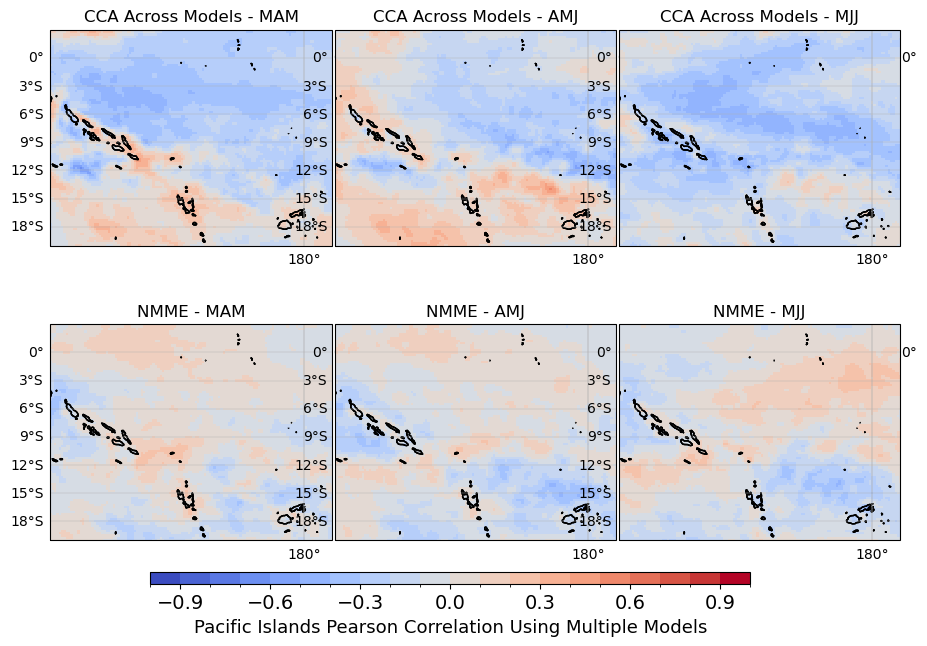

In [117]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature

# Assuming you have data for models and seasons
models = np.unique(pearsons.M.values)
seasons = target_months.copy()

fig, axes = plt.subplots(nrows=len(models), ncols=len(seasons), figsize=(10, (len(gcms)+1)*2 + 2), 
                         subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# Set the extent to cover the entire world
for ax in axes.flat:
    ax.set_global()

for j, model in enumerate(models):
    for i, season in enumerate(seasons):
        ax = axes[j, i]
        # Your plotting code here using the specific model and season
        xplot = pearsons.isel(L=i, M=j).plot(ax=ax,
                                              transform=ccrs.PlateCarree(),
                                              cmap='coolwarm', levels=21, vmin=-1, vmax=1, add_colorbar=False)
        ax.coastlines()
        c = ax.coastlines()
        c = ax.gridlines(draw_labels=True, linewidth=0.3)
        c.right_labels = False
        c.top_labels = False 
        # Add country borders
        ax.add_feature(NaturalEarthFeature(category='cultural', name='admin_0_countries', 
                                            scale='50m', edgecolor='black', facecolor='none'))
        # Set the extent to cover the specific area
        ax.set_extent([predictand_extent['west'], predictand_extent['east'], predictand_extent['south'], predictand_extent['north']], crs=ccrs.PlateCarree())
        ax.set_title(f'{model} - {season}')

# Add a single horizontal colorbar below the panel plot
cbar_ax = fig.add_axes([0.15, 0.002, 0.6, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(xplot, cax=cbar_ax, orientation='horizontal', shrink =1, pad = 0.3)
cbar.set_label('Pacific Islands Pearson Correlation Using Multiple Models', fontsize=13)
cbar.ax.tick_params(labelsize=14)
# Adjust layout
plt.subplots_adjust(left=0.05, right=0.9, top=0.95, bottom=0.05, wspace=0.01, hspace=0.2)

# Show plot
plt.savefig(os.path.join(figure_dir, 'pearson_CCA' + obs_name.split('.')[0]), bbox_inches='tight', dpi=100)

#### zoom in on a region of interest
can be kiribati_coordinates, fiji_coordinates, or solomon_coordinates, as setup in initial part of the noteobok

In [123]:
region_of_interest = 'Kiribati'
region_coords = kiribati_coordinates.copy()
region_coords

{'west': 155, 'east': 178, 'north': 2, 'south': 0}

NameError: name 'region_coordinates' is not defined

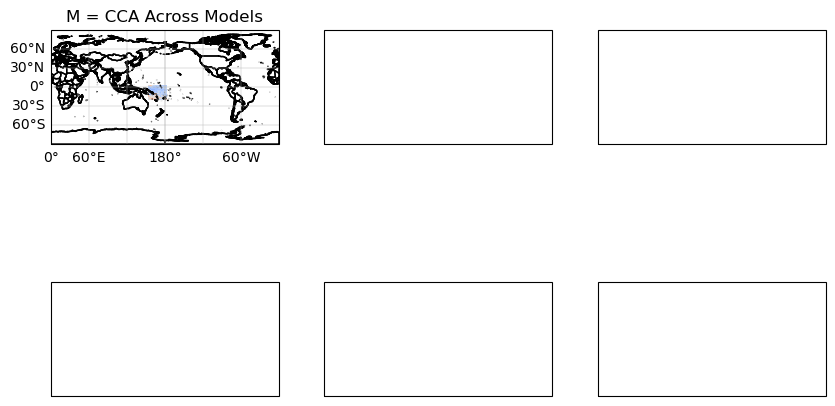

In [124]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature

# Assuming you have data for models and seasons
models = np.unique(pearsons.M.values)
seasons = target_months.copy()

fig, axes = plt.subplots(nrows=len(models), ncols=len(seasons), figsize=(10, (len(gcms)+1)*2 + 2), 
                         subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# Set the extent to cover the entire world
for ax in axes.flat:
    ax.set_global()

for j, model in enumerate(models):
    for i, season in enumerate(seasons):
        ax = axes[j, i]
        # Your plotting code here using the specific model and season
        xplot = pearsons.isel(L=i, M=j).plot(ax=ax,
                                              transform=ccrs.PlateCarree(),
                                              cmap='coolwarm', levels=21, vmin=-1, vmax=1, add_colorbar=False)
        ax.coastlines()
        c = ax.coastlines()
        c = ax.gridlines(draw_labels=True, linewidth=0.3)
        c.right_labels = False
        c.top_labels = False 
        # Add country borders
        ax.add_feature(NaturalEarthFeature(category='cultural', name='admin_0_countries', 
                                            scale='50m', edgecolor='black', facecolor='none'))
        # Set the extent to cover the specific area
        ax.set_extent([region_coords['west'], 
                       region_coords['east'], 
                       region_coords['south'], 
                       region_coords['north']], crs=ccrs.PlateCarree())
        ax.set_title(f'{model} - {season}')

# Add a single horizontal colorbar below the panel plot
cbar_ax = fig.add_axes([0.15, 0.002, 0.6, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(xplot, cax=cbar_ax, orientation='horizontal', shrink =1, pad = 0.3)
cbar.set_label(region_of_interest + ' Pearson Correlation Using Multiple Models', fontsize=13)
cbar.ax.tick_params(labelsize=14)
# Adjust layout
plt.subplots_adjust(left=0.05, right=0.9, top=0.95, bottom=0.05, wspace=0.01, hspace=0.2)

# Show plot
plt.savefig(os.path.join(figure_dir, region_of_interest + '-pearson_CCA' + obs_name.split('.')[0]), bbox_inches='tight', dpi=100)

## Plot some Probabalistic Plots

### Plot the Bias Corrected Forecasts using CCA

UNABLE TO FIND NAMES FOR FOLLOWING DIMS: ['sample']
UNABLE TO FIND NAMES FOR FOLLOWING DIMS: ['sample']
UNABLE TO FIND NAMES FOR FOLLOWING DIMS: ['sample']
UNABLE TO FIND NAMES FOR FOLLOWING DIMS: ['sample']
UNABLE TO FIND NAMES FOR FOLLOWING DIMS: ['sample']
UNABLE TO FIND NAMES FOR FOLLOWING DIMS: ['sample']


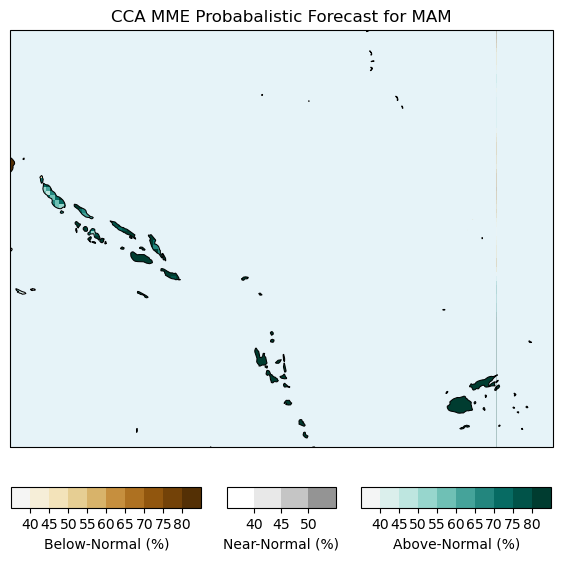

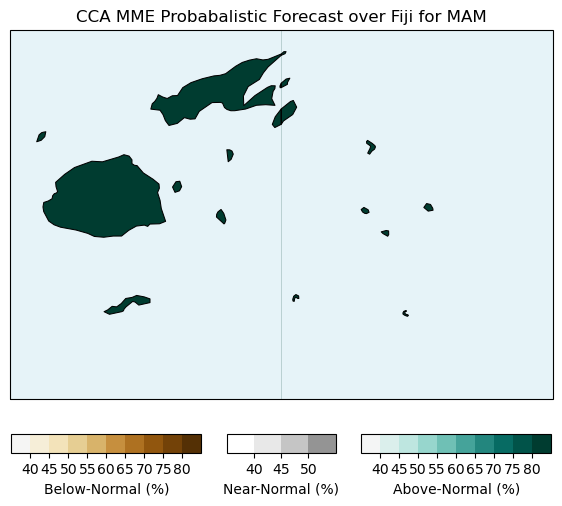

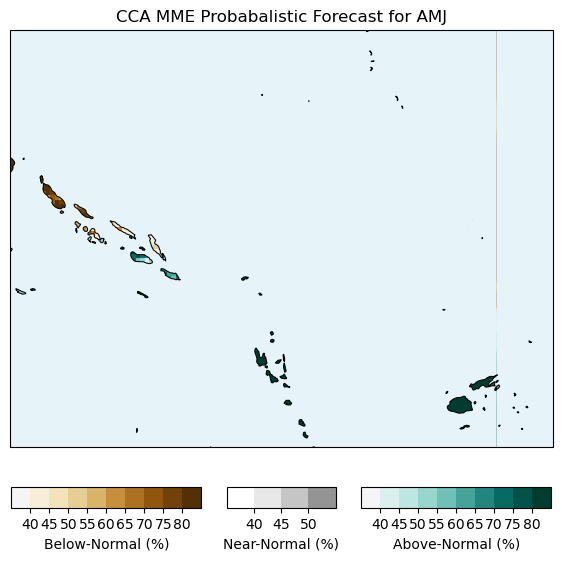

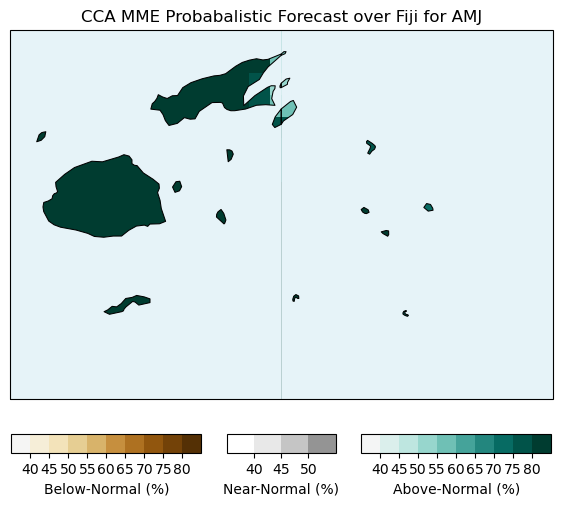

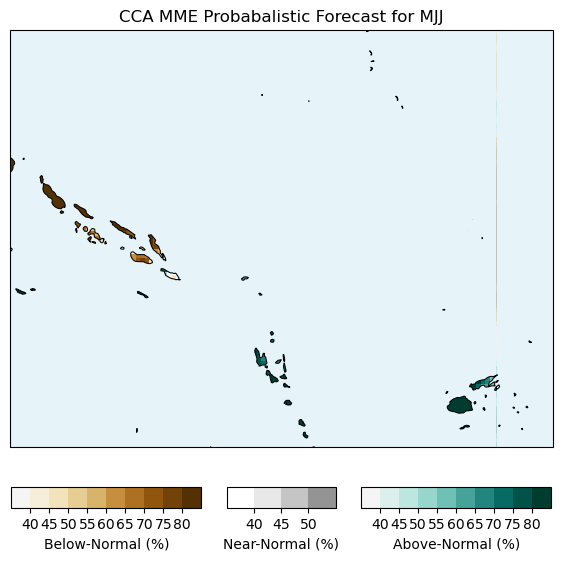

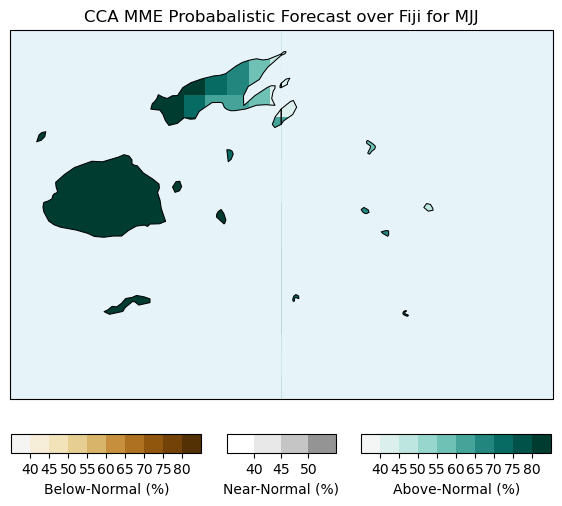

In [121]:
for l, lead in enumerate(np.unique(cca_fcsts_prob.L)):
    im = xc.view_probabilistic(cca_fcsts_prob.isel(T=0, L=l), cross_dateline=True,
                             title='CCA MME Probabalistic Forecast for ' + target_months[l],
                             savefig=os.path.join(figure_dir, target_seas[l] + 'CCA_forecast' + obs_name + '.png'))

    im_fiji = xc.view_probabilistic(cca_fcsts_prob.isel(T=0, L=l).sel(X=slice(177, 184),
                                                                   Y=slice(-20, -16)), cross_dateline=True,
                             title='CCA MME Probabalistic Forecast over Fiji for ' + target_months[l],
                             savefig=os.path.join(figure_dir, target_seas[l] + 'Fiji_CCA_forecast' + obs_name + '.png'))

#### Next Steps
~~1. Add environment install command to beginning of notebook~~
 Test our environment is stable on Windows with final version - install the environment on windows; and run this notebook
~~3. Test our environment is stable round two - instlal the environment on linux; and run this notebook
Give our document to others to test - Grace and Ehsan to run~~
Process other models in addition to NMME
Download data for other seasons (4 season skill) and upload to google drive
Run CCA on 5km UCSB and 25km CMORPH and time how long it takes
Add GROC skill score
Add RMSE skill score
Plot Raw Correlation score and CHECK
Plot Bias Corrected Correlation score
Develop an assignment for the practical session- divide into 4 teams; dividing by seasons - each calculate the raw score, bias corrected, plot the probabalistic forecast
Fix figure saving

Current run time for CCA
- 77 seconds for 25'; 35 seconds for 5km

In [ ]:
ohc = xc.OneHotEncoder() 
ohc.fit(obs.rename({'lat':'Y', 'lon':'X', 'time':'T'}))
#T = ohc.transform(obs)
# clim = xr.ones_like(T) * 0.333
# print(T)
# groc=xc.GROCS(hindcasts_prob1, T)
# pl=xc.view(groc,title='GROCS',cmap=plt.get_cmap('RdBu',8),vmin=0,vmax=1)

In [ ]:
# Create a figure
fig = plt.figure(figsize=(30, 20))

# Iterate over each month and plot the data
for i, month in enumerate(range(1, 33)):
    #print(month)
    # Add subplot to the figure
    ax = fig.add_subplot(8, 4, i+1, projection=ccrs.PlateCarree(central_longitude=180))

    # Plot data for the current month
    im =hindcasts_det1.isel(M=0, time=i).plot(transform=ccrs.PlateCarree(),
                                              subplot_kws={'projection':ccrs.PlateCarree(central_longitude=180)},
                                             vmin=0,vmax=10)

In [ ]:
# Create a figure
fig = plt.figure(figsize=(30, 20))

# Iterate over each month and plot the data
for i, month in enumerate(range(1, 33)):
    #print(month)
    # Add subplot to the figure
    ax = fig.add_subplot(8, 4, i+1, projection=ccrs.PlateCarree(central_longitude=180))

    # Plot data for the current month
    im =obs.isel(year=i).plot(transform=ccrs.PlateCarree(),
                                              subplot_kws={'projection':ccrs.PlateCarree(central_longitude=180)},
                                             vmin=0,vmax=10)

In [ ]:
hindcasts_det.isel(M=0,time=3).plot()

In [ ]:
splot = chirps_pacisl.precip.plot(col = 'time', col_wrap = 5,subplot_kws={'projection':ccrs.PlateCarree()})
                                  # (transform.ccrs.PleteCareer(), vmin=0, vmax = 600, levels=21)
#splot = splot.plot(transform.ccrs.PleteCareer(), vmin=0, vmax = 600, levels=21)
for ax in  splot.axs.flat:
    coasts = ax.coastlines()
    ax.set_xlim(pred_w, pred_e)
    ax.set_ylim(pred_s, pred_n)
plt.show()

In [ ]:
hmodelt = nmme_mme_hcst.precip.expand_dims({'M':[0]})
fmodelt = nmme_mme_fcst.precip.expand_dims({'M':[0]})
obs = chirps_hcst.precip.expand_dims({'M':[0]})

drymask = xc.drymask(obs, dry_threshold= cfg.dry_threshold)#, quantile_threshold=cfg.quantile_threshold)
obs = obs*drymask
drymask = xc.drymask(hmodelt, cfg.dry_threshold, cfg.quantile_threshold)
modelt = hmodelt*drymask